# Multi-Class Prediction of Obesity Risk

The data consist of the estimation of obesity levels in people from the countries of Mexico, Peru and Colombia, with ages between 14 and 61 and diverse eating habits and physical condition , data was collected using a web platform with a survey where anonymous users answered each question
Data contains info related to eating habits (e.g., frequent consumption of high caloric food, daily water consumption) and physical activity (e.g., physical activity frequency, time using technology devices)
We're going to predict a binary variable: obese or not. Our dataset contains different classifications that we're going to binarize (insufficient weight, normal weight, overweight levels I and II, obese levels I, II, III).
Obesity classification was done purely based on BMI



#### load modules

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

#### load data

In [10]:
data_path = '/Users/andrew/Documents/GitHub/data_science/obesity_prediction/data/'
df = pd.read_csv(data_path + 'train.csv')

#### do a bit of preprocessing
convert categorical variables to dummy variables.
not normalizing or centering because non-categorical variables are already on about the same scale

In [11]:
# Convert categorical (or binary) variables to dummy variables (one-hot encoded)
catVars = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']

for ii in catVars:

    # create the dummy variable
    dummy = pd.get_dummies(df[ii], drop_first=True)

    # remove the original variable
    df.drop(ii, axis = 1, inplace=True)

    # add the dummified variable
    df = pd.concat([df, dummy],axis=1)

# drop height and weight from table
df.drop(['Height','Weight'], axis=1, inplace=True)

# convert the variable referencing 'consumption of food between meals' to integer values
vals = np.arange(4)
keywords = ['no', 'Sometimes', 'Frequently', 'Always']
for ii, kw in enumerate(keywords):
    df.loc[df['CAEC']==kw, 'CAEC'] = vals[ii]

# do the same with alcohol consumption
vals = np.arange(3)
keywords = ['no','Sometimes','Frequently']
for ii, kw in enumerate(keywords):
    df.loc[df['CALC']==kw, 'CALC'] = vals[ii]

# and the obesity level
vals = np.arange(7)
keywords = ['Insufficient_Weight','Normal_Weight','Overweight_Level_I','Overweight_Level_II',
            'Obesity_Type_I','Obesity_Type_II','Obesity_Type_III']
for ii, kw in enumerate(keywords):
    df.loc[df['NObeyesdad']==kw, 'NObeyesdad'] = vals[ii]

# convert the obesity level to a binary variable
df.loc[df['NObeyesdad'] < 4, 'NObeyesdad'] = 0
df.loc[df['NObeyesdad'] >= 4,'NObeyesdad'] = 1

# toss the id column
df.drop('id', axis=1, inplace=True)

In [19]:
# separate out our training and test data
# fraction of data to use for training
train_fraction = 0.9
num_train = round(df.shape[0] * train_fraction)

df_train = df.iloc[:num_train]
df_test  = df.iloc[num_train:]

#### Logistic regression
This will be our baseline
no regularization

In [29]:
from sklearn.linear_model import LogisticRegression

# pull out the train X and train Y data
X_train = np.array(df_train.iloc[:, df.columns != 'NObeyesdad'])
Y_train = np.array(df_train.iloc[:, df.columns == 'NObeyesdad']).astype('bool')[:,0]

# pull out the test data
X_test = np.array(df_test.iloc[:, df.columns != 'NObeyesdad'])
Y_test = np.array(df_test.iloc[:, df.columns == 'NObeyesdad']).astype('bool')[:,0]

# initialize our model
model_logReg = LogisticRegression(penalty=None, max_iter=500)

# fit the model
model_logReg.fit(X_train,Y_train)

# test the model
Y_hat = model_logReg.predict(X_test)

# calculate accuracy
baseline_score = sum(Y_test == Y_hat) / len(Y_test)
print('classification accuracy: ' + str(baseline_score))

# initialize a dictionary to keep track of our scores
all_scores = {'baseline': baseline_score}

classification accuracy: 0.8034682080924855


#### Not bad (certainly above chance), but we can clearly do better
as a simple start, at L2 regularization to combat overfitting (likely not an issue, given the small number of parameters)

In [30]:
# magnitude of L2 penalty (0-1, with lower values corresponding to a greater penalty)
l2_lam = np.logspace(-5,stop=1, num=8)[::-1]
num_lams = len(l2_lam)

# fit each in turn
model_logReg_l2 = [None] * num_lams

# list to keep track of scores with different l2 penalties
l2_score = []
for ii,ll in enumerate(l2_lam):

    model_logReg_l2[ii] = LogisticRegression(penalty='l2', C=ll, max_iter=500 )

    # fit the model
    model_logReg_l2[ii].fit(X_train,Y_train)

    # test the model
    Y_hat = model_logReg_l2[ii].predict(X_test)

    # calculate accuracy
    score = sum(Y_test == Y_hat) / len(Y_test)
    l2_score.append(score)

    # display result as fractional improvement over baseline
    pct_dScore = (score - baseline_score) / baseline_score
    print('percent change in classification accuracy: ' + str(pct_dScore))

# add the best score to the dictionary
all_scores['l2_reg'] = np.max(l2_score)

percent change in classification accuracy: 0.0
percent change in classification accuracy: -0.000599520383692982
percent change in classification accuracy: -0.000599520383692982
percent change in classification accuracy: 0.007194244604316612
percent change in classification accuracy: -0.002997601918465186
percent change in classification accuracy: -0.04856115107913665
percent change in classification accuracy: -0.09232613908872903
percent change in classification accuracy: -0.1109112709832134


#### Very tiny improvement in performance with moderate normalization

#### Before we change up the model architecture, let's see if we can get any improvements by handling the input data more intelligently (i.e., 'feature engineering') .
First, we're going to bin the ages by decade (whether a person is 30 or 33 likely does not greatly change their likelihood of being obese)
We're also going to log-transform the ages, as the fraction of obese individuals changes dramatically as a function of age during early-middle age


In [31]:
# add a 'binned age' column to the dataframe
df['age_bin'] = pd.cut(df['Age'], bins=[10,20,30,40,50,60,70],labels=[0,1,2,3,4,5])

# log transform the ages
df['log_age'] = np.log1p(df['Age'])

In [34]:
# pull out the test and train data again
X_df = df.copy()
Y = np.array(X_df['NObeyesdad']).astype('bool')
X_df.drop(['NObeyesdad'],axis=1,inplace=True)
X = np.array(X_df)


# pull out the train X and train Y data
X_train = X[:num_train,:]
Y_train = Y[:num_train]

# pull out the test data
X_test = X[num_train:,:]
Y_test = Y[num_train:]

In [38]:
# train models (with l2 regularization and feature engineering)
model_logReg_l2_fe = [None] * num_lams

# list to keep track of scores
fe_scores = []
for ii,ll in enumerate(l2_lam):

    model_logReg_l2_fe[ii] = LogisticRegression(penalty='l2', C=ll, max_iter = 500 )

    # fit the model
    model_logReg_l2_fe[ii].fit(X_train,Y_train)

    # test the model
    Y_hat = model_logReg_l2_fe[ii].predict(X_test)

    # calculate accuracy
    score = sum(Y_test == Y_hat) / len(Y_test)
    fe_scores.append(score)

    # display result as fractional improvement over baseline
    pct_dScore = (score - baseline_score) / baseline_score
    print('percent change in classification accuracy: ' + str(pct_dScore))

# save the best score
all_scores['feature_engineering'] = np.max(fe_scores)

/Users/andrew/miniconda3/envs/jobPrep/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


percent change in classification accuracy: 0.0227817745803358


/Users/andrew/miniconda3/envs/jobPrep/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


percent change in classification accuracy: 0.025779376498800986
percent change in classification accuracy: 0.01079136690647478
percent change in classification accuracy: 0.01079136690647478
percent change in classification accuracy: 0.0005995203836931201
percent change in classification accuracy: -0.045563549160671464
percent change in classification accuracy: -0.09292565947242201
percent change in classification accuracy: -0.1121103117505995


#### So that feature engineering (plus regularization) brought us from ~0.8 to ~0.82 accuracy

#### Now it's time to switch things up with a different model architecture
We're going to start with a feedforward network (relu units, trained with dropout)

In [40]:
# define some parameters for our network
num_units_per_layer = 300
num_hidden_layers = 10
batch_size = 1000
num_epochs = 500
dropout_p  = 0.1
input_dim = X_train.shape[1]

In [41]:
import sys
sys.path.append('/Users/andrew/Documents/GitHub/data_science/obesity_prediction/code/')
from torch.utils.data import DataLoader
import utils
import torch

# define the dataset and dataloader (both make passing data to the model easier)
dataset    = utils.FF_dataset(data=X_train.astype('float16'), targets=Y_train.astype('float16').reshape(-1,1))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

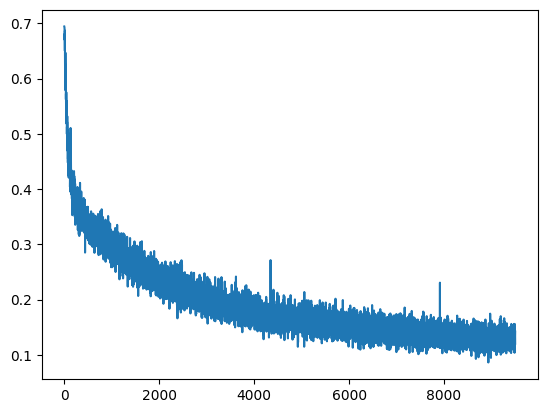

In [42]:
# initialize the network
net = utils.FF_network(input_dim=input_dim, num_hidden_layers=num_hidden_layers,
                               num_units_per_layer=num_units_per_layer, dropout_p=dropout_p)
# define an optimizer (using default ADAM parameters)
# get a list of the named parameters
optimizer = torch.optim.Adam(net.parameters())

# use a simple MSE loss function
criterion = torch.nn.BCELoss()

# train the network
allLoss = []

for epoch in range(num_epochs):

    for ii, (x, y) in enumerate(dataloader):

        # make sure we're in training mode (the drop-out layers are active)
        net.train()

        # clear the gradient
        optimizer.zero_grad()

        # forward pass
        out = net(x)

        # calculate loss
        loss = criterion(out, y)
        allLoss.append(loss.detach().numpy())

        # calculate gradient
        loss.backward()

        # update parameters
        optimizer.step()

# plot the loss across batches
plt.plot(allLoss);

In [43]:
# test on the held-out data
net.eval()
Y_hat = net(torch.Tensor(X_test.astype('float16')))
Y_hat = Y_hat.detach().numpy()[:,0]

# convert to prediction
Y_hat[Y_hat<0.5] = 0
Y_hat[Y_hat>=0.5] = 1

# calculate accuracy
score = sum(Y_test == Y_hat) / len(Y_test)

# display result as fractional improvement over baseline
pct_dScore = (score - baseline_score) / baseline_score
print('classification accuracy: ' + str(score))
print('percent change in classification accuracy: ' + str(pct_dScore))

# save the score
all_scores['ff_net'] = score

classification accuracy: 0.867533718689788
percent change in classification accuracy: 0.07973621103117502


#### Now things are looking better.
Let's optimize the hyperparameters with a simple grid search
Will choose hyperparameters using performance on a validation set

In [44]:
# define our hyperparameter grid
units_per_layer_grid = np.linspace(200,500,3)
num_layers_grid      = np.linspace(5,50,3)
p_dropout_grid       = np.linspace(0.05,0.6,3)

In [45]:
# define our train and validation sets
percent_validation = 0.1
numValidation = round(X_train.shape[0] * percent_validation)

X_val = X_train[:numValidation,:]
Y_val = Y_train[:numValidation]
X_train_search = X_train[numValidation:,:]
Y_train_search = Y_train[numValidation:]

# each model is going to be trained until the validation error starts to increase.
# define the number of epochs in each 'cycle'
num_epochs_per_cycle = 15

# define a new dataset and dataloader
dataset_search    = utils.FF_dataset(data=X_train_search.astype('float16'), targets=Y_train_search.astype('float16').reshape(-1,1))
dataloader_search = DataLoader(dataset_search, batch_size=batch_size, shuffle=True)

In [46]:
# initialize array to hold validation set performance
val_accuracy = np.zeros((3,3,3)) * np.nan

# cycle through the hyperparameters
for ii,units in enumerate(units_per_layer_grid):
    for jj, layers in enumerate(num_layers_grid):
        for kk, pDrop in enumerate(p_dropout_grid):

            # initialize the network
            net = utils.FF_network(input_dim=input_dim, num_hidden_layers=int(layers),
                                           num_units_per_layer=int(units), dropout_p=pDrop)

            # define an optimizer (using default ADAM parameters)
            # get a list of the named parameters
            optimizer = torch.optim.Adam(net.parameters())

            # use a simple MSE loss function
            criterion = torch.nn.BCELoss()

            # keep track of the validation loss
            valScore = -np.inf
            contFlg = True
            cycleCounter=0

            # run through epochs as long as the validation loss is decreasing
            while contFlg:
                display('cycle number: ' + str(cycleCounter))

                for epoch in range(num_epochs_per_cycle):

                    for i, (x, y) in enumerate(dataloader_search):

                        # make sure we're in training mode (the drop-out layers are active)
                        net.train()

                        # clear the gradient
                        optimizer.zero_grad()

                        # forward pass
                        out = net(x)

                        # calculate loss
                        loss = criterion(out, y)

                        # calculate gradient
                        loss.backward()

                        # update parameters
                        optimizer.step()

                # calculate loss on validation data
                net.eval()
                Y_hat = net(torch.Tensor(X_val.astype('float16')))
                Y_hat = Y_hat.detach().numpy()[:,0]

                # convert to prediction
                Y_hat[Y_hat<0.5] = 0
                Y_hat[Y_hat>=0.5] = 1

                # calculate accuracy
                score = sum(Y_val == Y_hat) / len(Y_test)

                # check to see if validation loss decreased
                if score > valScore:
                    valScore = np.copy(score)
                    cycleCounter+=1
                else:
                    contFlg = False
                    val_accuracy[ii,jj,kk] = valScore


'cycle number: 0'

'cycle number: 1'

'cycle number: 2'

'cycle number: 3'

'cycle number: 4'

'cycle number: 5'

'cycle number: 0'

'cycle number: 1'

'cycle number: 2'

'cycle number: 3'

'cycle number: 0'

'cycle number: 1'

'cycle number: 2'

'cycle number: 3'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 2'

'cycle number: 3'

'cycle number: 0'

'cycle number: 1'

'cycle number: 2'

'cycle number: 3'

'cycle number: 4'

'cycle number: 5'

'cycle number: 6'

'cycle number: 0'

'cycle number: 1'

'cycle number: 2'

'cycle number: 3'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 2'

'cycle number: 3'

'cycle number: 0'

'cycle number: 1'

'cycle number: 2'

'cycle number: 3'

'cycle number: 0'

'cycle number: 1'

'cycle number: 2'

'cycle number: 3'

'cycle number: 4'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

'cycle number: 0'

'cycle number: 1'

In [48]:
import scipy

# interpolate to get higher resolution
units_per_layer_grid_int = np.linspace(200,500,10)
num_layers_grid_int     = np.linspace(5,50,10)
p_dropout_grid_int      = np.linspace(0.05,0.6,10)

# generate 2D array of our known data points
xv, yv, zv = np.meshgrid(units_per_layer_grid, num_layers_grid, p_dropout_grid, indexing='ij')
points = np.concatenate([x.reshape(-1,1,order='F') for x in [xv, yv, zv]],axis=1)

# make a 2D array of the desired data point
xv, yv, zv = np.meshgrid(units_per_layer_grid_int, num_layers_grid_int, p_dropout_grid_int, indexing='ij')

# flatten our values
val_flat = val_accuracy.reshape(-1,1,order='F');

# interpolate
interp_grid = scipy.interpolate.griddata(points, val_flat, (xv, yv, zv), method='linear')

# find the maximum (interpolated) value)
m_ii, m_jj, m_kk = np.unravel_index(np.argmax(interp_grid), (10,10,10), order='C')

# pull out the parameters associated with the maximum value
units_per_layer_opt = units_per_layer_grid_int[m_ii]
num_layers_grid_opt = num_layers_grid_int[m_jj]
p_dropout_grid_opt  = p_dropout_grid_int[m_kk]

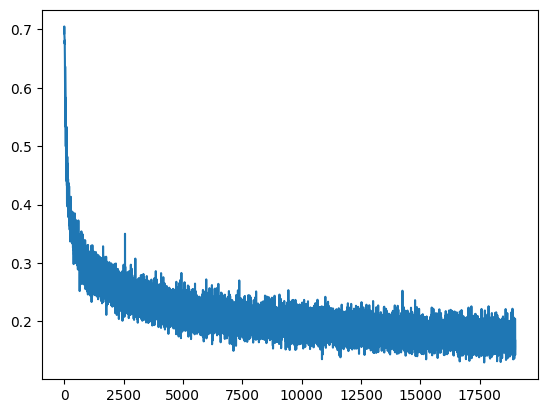

In [49]:
# train a new network with these parameters

# up the number of epochs
num_epochs = 1000

# initialize the network
net = utils.FF_network(input_dim=input_dim, num_hidden_layers=int(num_layers_grid_opt),
                               num_units_per_layer=int(units_per_layer_opt), dropout_p=p_dropout_grid_opt)

# define an optimizer (using default ADAM parameters)
# get a list of the named parameters
optimizer = torch.optim.Adam(net.parameters())

# use a simple MSE loss function
criterion = torch.nn.BCELoss()

# train the network
allLoss = []

for epoch in range(num_epochs):

    for ii, (x, y) in enumerate(dataloader):

        # make sure we're in training mode (the drop-out layers are active)
        net.train()

        # clear the gradient
        optimizer.zero_grad()

        # forward pass
        out = net(x)

        # calculate loss
        loss = criterion(out, y)
        allLoss.append(loss.detach().numpy())

        # calculate gradient
        loss.backward()

        # update parameters
        optimizer.step()

# plot the loss
plt.plot(allLoss);

In [50]:
# test on the held-out data
net.eval()
Y_hat = net(torch.Tensor(X_test.astype('float16')))
Y_hat = Y_hat.detach().numpy()[:,0]

# convert to prediction
Y_hat[Y_hat<0.5] = 0
Y_hat[Y_hat>=0.5] = 1

# calculate accuracy
score = sum(Y_test == Y_hat) / len(Y_test)

# save accuracy
all_scores['ff_net_opt'] = score

# display result as fractional improvement over baseline
pct_dScore = (score - baseline_score) / baseline_score
print('classification accuracy: ' + str(score))
print('percent change in classification accuracy: ' + str(pct_dScore))

classification accuracy: 0.8723506743737958
percent change in classification accuracy: 0.08573141486810554


#### Things are looking much better now, but let's see how much things improve by 'ensembling' models

### our first ensemble is going to be a random forest classifier.
Before we get to that, let's look at how a single tree performs

In [51]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,Y_train)
Y_hat = clf.predict(X_test)

# calculate accuracy
score = sum(Y_test == Y_hat) / len(Y_test)
print('classification accuracy: ' + str(score))

# save score
all_scores['decision_tree'] = score

classification accuracy: 0.8660886319845857


#### surprisingly, a simple decision tree nearly beats our optimized network!

#### train a random forest classifier
very simple emsemble method. We're going to train a bunch of individual decision trees on bootstrapped collections of the data. This method nicely combats overfitting.
the final prediction is made by allowing each tree to 'vote'. Most popular classification wins.


In [52]:
from numpy.random import choice

# number of trees in our forest
num_trees = 100

# for each tree, bootstrap our training data

# number of training samples
num_samples  = X_train.shape[0]

# list to hold our trees
Trees = []
for ii in range(num_trees):

    # get the bootstrapped data
    idx = choice(np.arange(num_samples), num_samples)
    Trees.append(tree.DecisionTreeClassifier().fit(X_train[idx,:], Y_train[idx]))



In [53]:
# get the predictions of each tree within the forest (on the test data). Count votes to decide final answer
test_out = [tree.predict(X_test) for tree in Trees]

# convert into array
test_out_array = np.array(test_out)

# find most popular output for each input
Y_hat = np.sum(test_out_array, axis=0) >= (num_trees/2)

# calculate accuracy
score = sum(Y_test == Y_hat) / len(Y_test)
print('classification accuracy: ' + str(score))

# save result
all_scores['random_forest_scratch'] = score

classification accuracy: 0.8872832369942196


#### the random forest classifier is beating our network handily!
just for comparison, use the built-in random forest classifier

In [54]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
clf.fit(X_train,Y_train)

Y_hat = clf.predict(X_test)

# calculate accuracy
score = sum(Y_test == Y_hat) / len(Y_test)
print('classification accuracy: ' + str(score))

# save result
all_scores['random_forest_sklearn'] = score

classification accuracy: 0.9065510597302505


#### Now we're easily beating our network
Seems like we top out at ~0.907 classification accuracy

#### Try a gradient boosting classifier
Another popular ensemble method. Here, we add decision trees linearly, and train each successive tree on the gradient (loss wrt change in tree parameters) of the previous tree.

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(validation_fraction = 0.1, n_estimators = 1000)
clf.fit(X_train,Y_train)

Y_hat = clf.predict(X_test)

# calculate accuracy
score = sum(Y_test == Y_hat) / len(Y_test)
print('classification accuracy: ' + str(score))

# save result
all_scores['gradiant_boosting'] = score

classification accuracy: 0.903179190751445


#### The kitchen sink
Here, we're going to train a few different ensemble methods, and use the output of each ensemble as input to a final logistic classifier.
While this method could very likely outperform all others (for obvious reasons), doing so may require a significant amount of hyperparameter optimization.

In [56]:
# import all of the classifiers we haven't already
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

# number of estimators per base ensemble
n_estimators = 500

# make a list of the estimators
estimators = [('ada', AdaBoostClassifier(n_estimators = n_estimators)),
              ('bag', BaggingClassifier(n_estimators = n_estimators)),
              ('ext', ExtraTreesClassifier(n_estimators = n_estimators)),
              ('grd', GradientBoostingClassifier(n_estimators = n_estimators)),
              ('rdm', RandomForestClassifier(n_estimators = n_estimators))]

clf = StackingClassifier(estimators = estimators, final_estimator=LogisticRegression(), n_jobs=-1)
clf.fit(X_train,Y_train)

StackingClassifier(estimators=[('ada', AdaBoostClassifier(n_estimators=500)),
                               ('bag', BaggingClassifier(n_estimators=500)),
                               ('ext', ExtraTreesClassifier(n_estimators=500)),
                               ('grd',
                                GradientBoostingClassifier(n_estimators=500)),
                               ('rdm',
                                RandomForestClassifier(n_estimators=500))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [57]:
# check accuracy
Y_hat = clf.predict(X_test)

# calculate accuracy
score = sum(Y_test == Y_hat) / len(Y_test)
print('classification accuracy: ' + str(score))

# save score
all_scores['kitchen_sink_emsemble'] = score

classification accuracy: 0.9026974951830443


#### Summarize performance of all of our classifiers

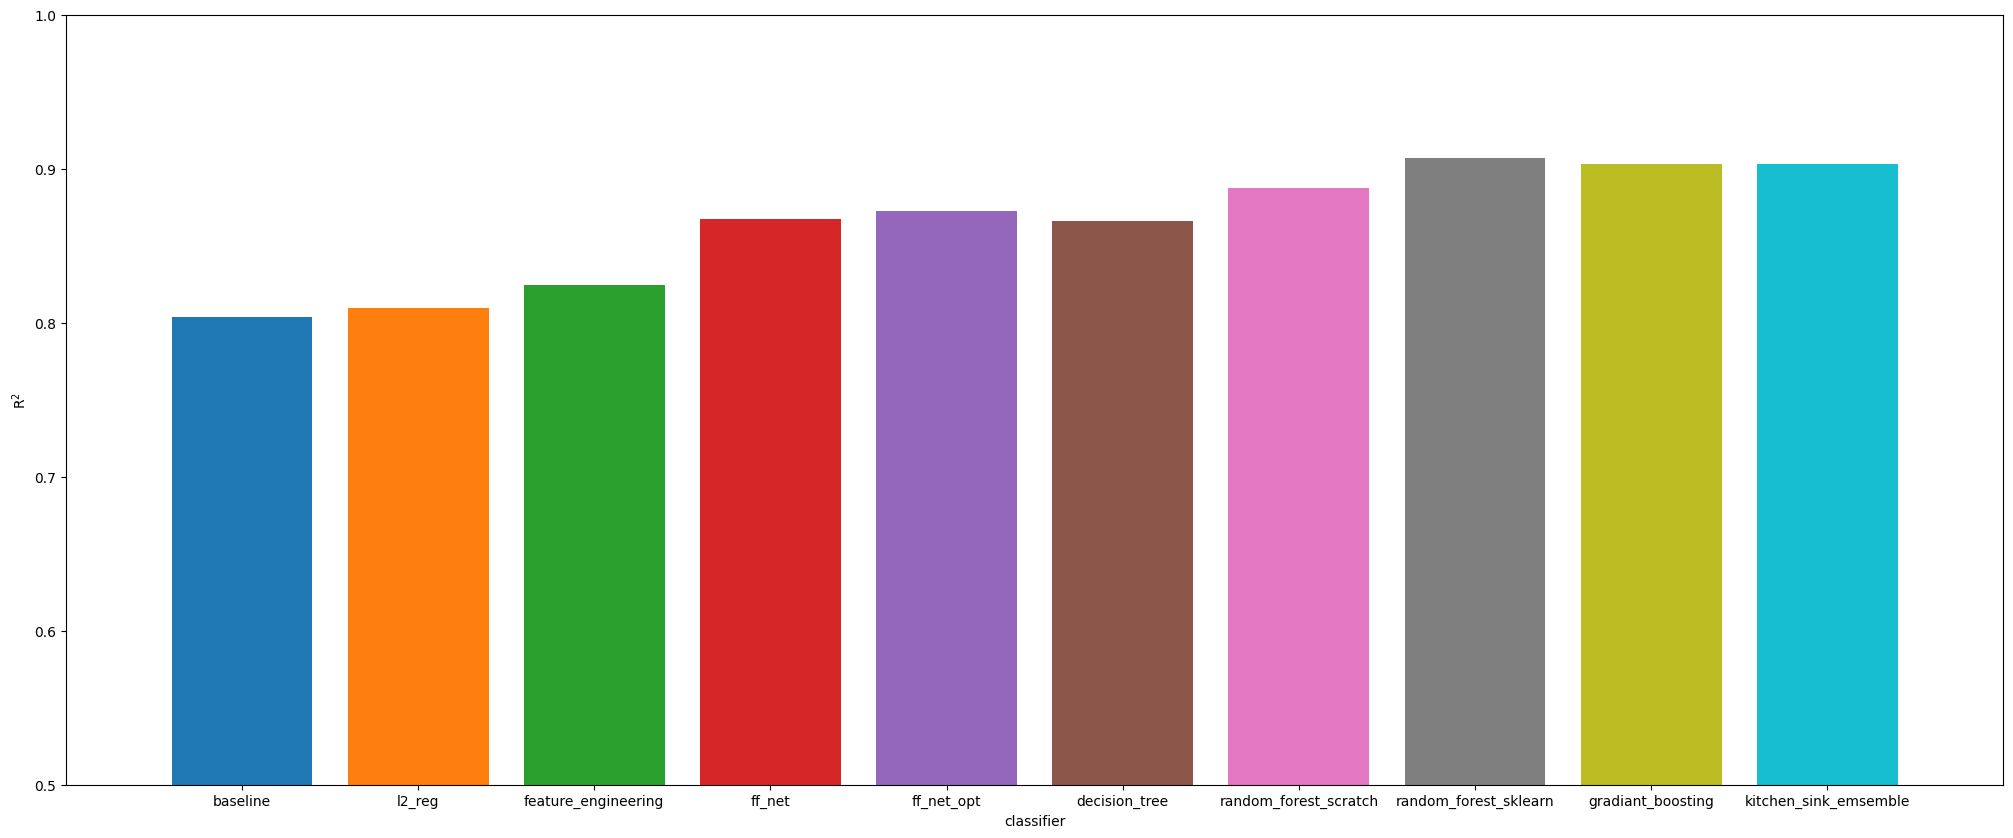

In [59]:
plt.figure(figsize=(25,10));

# number of classifiers
num_class = len(all_scores)

# performance of each classifier
score_vals = list(all_scores.values())

# name of each classifier
class_names = all_scores.keys()

# plot
for ii in range(num_class):

    plt.bar(ii,score_vals[ii]);

# clean up
plt.xlim([-1,num_class]);
plt.ylim([0.5, 1]);
plt.ylabel('R$^2$');
plt.xlabel('classifier');
plt.xticks(ticks=np.arange(num_class), labels=class_names);


#### Summary of training various classifiers

decision tree (and ensembles of decision trees) perform comparably (or better) than feedforward networks, while requiring a fraction of the training time.

I only got a very modest improvement with my hyperparameter grid search (for the FF network). I likely would see a larger improvement with a more comprehensive/more intelligent search. For example, rather than a simple grid search, I could've used bayesian optimization.

## Explore the dataset
now that we've maxed out our classifier performance, let's use a few of the simpler classifiers to explore the relationship between the various variables and obesity

In [135]:
# pull out the names of each of the variables
# we appended the dummy variables in the order: 'Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS'

# pull out the variable names, drop 'NObeyesdad', replace the dummy variable names with more informative names
var_names = list(df.columns[df.columns != 'NObeyesdad'])

# find the index where we started appending dummy variables
gIdx = [ii for ii, x in enumerate(var_names) if x=='Male' or x=='Female'][0]

# replace with more informative names
var_names[gIdx] = 'Gender'
var_names[gIdx+1] = 'family_history_overweight'
var_names[gIdx+2] = 'FAVC'
var_names[gIdx+3] = 'smoke'
var_names[gIdx+4] = 'SCC'
transport = ['bike','motorbike','public_transit','walking']
for ii in range(5,9):
    var_names[gIdx+ii] = transport[ii-5]


classification accuracy: 0.8126204238921002


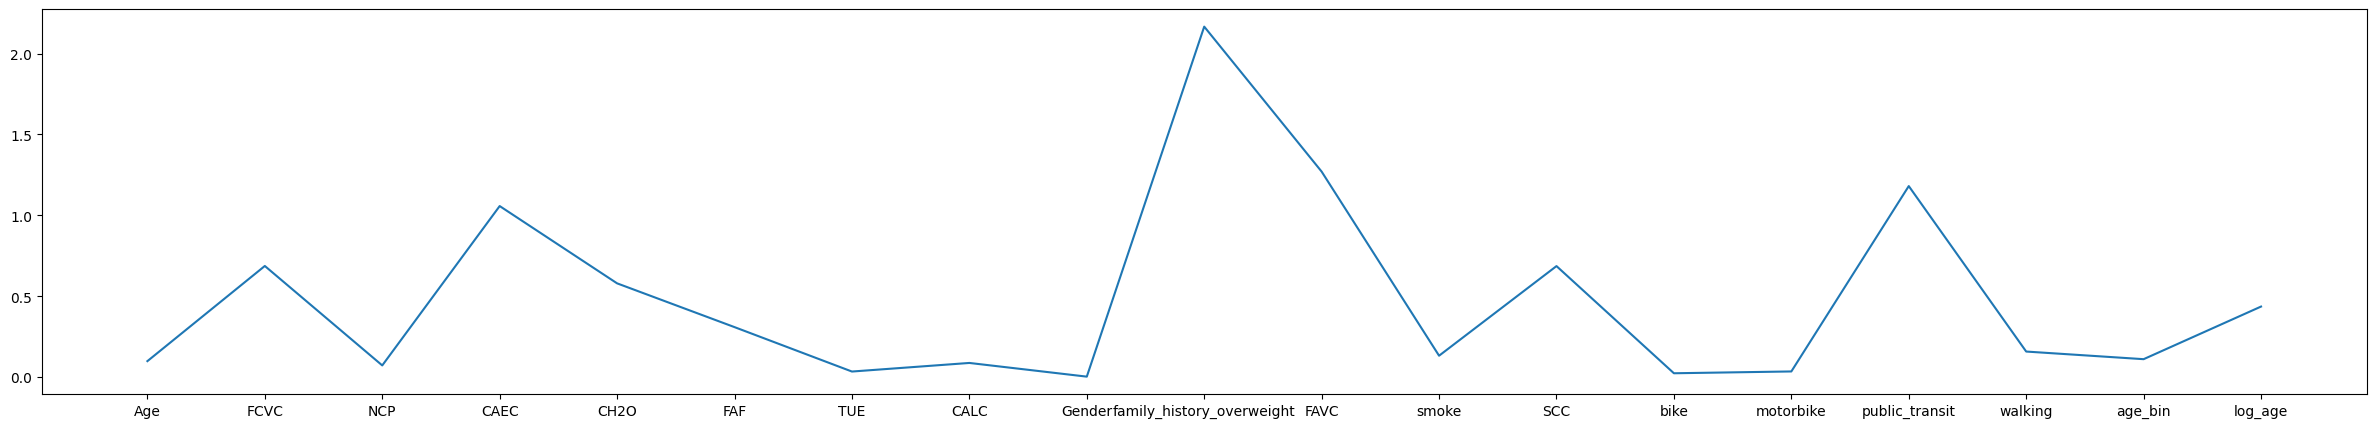

In [138]:
# train a logistic regression classifier
model = LogisticRegression(penalty='l2', C=1e-2, max_iter=500 )

# fit the model
model.fit(X_train,Y_train)

# test the model
Y_hat = model.predict(X_test)

# calculate and display accuracy
score = sum(Y_test == Y_hat) / len(Y_test)
print('classification accuracy: ' + str(score))

# pull out the coefficients
coefs = model.coef_[0,:]

# plot the coefficients
plt.figure(figsize=(30,5));
plt.plot(abs(coefs));
plt.xticks(np.arange(len(coefs)), labels=var_names);

we didn't normalize our variables, so we can only get a rough idea about how 'important' each of the variables are to the prediction. But from a first pass, it seems that family history of being overweight, consuming food between meals, and whether or not the person takes public transportation to work are the most informative variables

To verify this impression, get p-values for each of the coefficients

In [190]:
result.pvalues

array([9.99354507e-096, 9.13101660e-080, 3.29090314e-001, 4.70498221e-126,
       7.86738489e-072, 1.81002850e-045, 8.18746921e-004, 3.19943827e-002,
       8.12247162e-001, 3.38769064e-200, 1.17868707e-101, 1.88557986e-004,
       4.48707981e-028, 7.21448878e-001, 2.15925799e-001, 1.27577895e-105,
       1.08753904e-001, 6.40467659e-006, 1.39408256e-263])

In [139]:
import statsmodels.api as sm

model=sm.Logit(Y_train.astype('float32'),X_train.astype('float32'))
result=model.fit()

# plot the inverse of the P-values
# sort the p-values
idx = np.argsort(result.pvalues)

# print the variables in order
sorted_vars = [var_names[x] for x in idx]
print('sorted variables: ')
print(sorted_vars);


Optimization terminated successfully.
         Current function value: 0.441344
         Iterations 8
sorted variables: 
['log_age', 'family_history_overweight', 'CAEC', 'public_transit', 'FAVC', 'Age', 'FCVC', 'CH2O', 'FAF', 'SCC', 'age_bin', 'smoke', 'TUE', 'CALC', 'walking', 'motorbike', 'NCP', 'bike', 'Gender']


This is why we need to be careful about interpreting the magnitude of the coefficients if we don't normalize them! 'Log-age' is by far the 'most important' variable (p < 1e-263, while the next closest variable has a value of < 1e-200).

In [142]:
# I'm now going to re-train the model with only the 5 most 'useful' variables
X_train_ds = X_train[:,idx[:5]]

# train a logistic regression classifier
model = LogisticRegression(penalty='l2', C=1e-2, max_iter=500 )

# fit the model
model.fit(X_train_ds,Y_train)

# test the model
Y_hat = model.predict(X_test[:,idx[:5]])

# calculate and display accuracy
score = sum(Y_test == Y_hat) / len(Y_test)
print('classification accuracy: ' + str(score))

#

classification accuracy: 0.7967244701348748


after getting rid of 14 of the 19 variables, we're still able to predict nearly as well as if we used all of the variables (98% as well).
In fact, if we only use 'log age', we can predict 89% as well (0.72 prediction accuracy on held-out data).

In [145]:
# I'm now going to re-train the model with only the 5 most 'useful' variables
X_train_ds = X_train[:,idx[:1]]

# train a logistic regression classifier
model = LogisticRegression(penalty='l2', C=1e-2, max_iter=500 )

# fit the model
model.fit(X_train_ds,Y_train)

# test the model
Y_hat = model.predict(X_test[:,idx[:1]])

# calculate and display accuracy
score = sum(Y_test == Y_hat) / len(Y_test)
print('classification accuracy: ' + str(score))

classification accuracy: 0.7235067437379576


### To verify that this is true, do a simple analysis where we define single threshold. If an individual's log age is greater than that threshold, they're predicted to be obese.
Sweep this threshold across a range and ask how our performance changes.

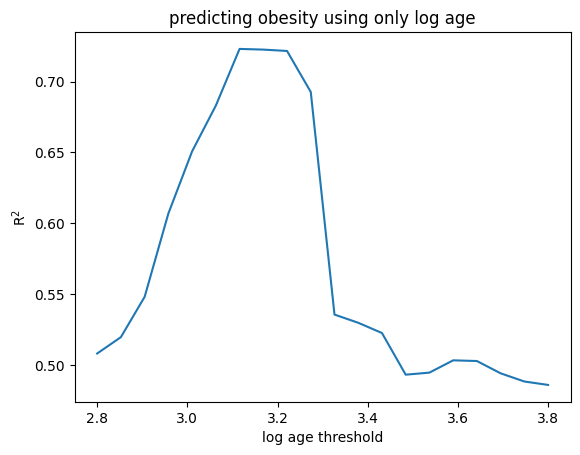

In [180]:
# define our thresholds
threshold = np.linspace(2.8,3.8,num=20);

# pull out the
log_age = X_test[:,idx[0]]

# keep track of our scores
scores = []

# run analysis
for tt in threshold:
    Y_hat = np.zeros_like(Y_test)
    Y_hat[log_age >= tt] = 1

    # calculate score
    score = sum(Y_test == Y_hat) / len(Y_test)
    scores.append(score)

# plot results
plt.plot(threshold,scores);
plt.xlabel('log age threshold');
plt.ylabel('R$^2$');
plt.title('predicting obesity using only log age');